${}^{27}\textrm{Al}(p,\alpha)$ Analysis
=======================================

Initial trial for running my analysis code. Since this is still exploratory, I'm just using the notebook until I get a final batch running and set up.

In [60]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy

import pyne

In [61]:
e = pyne.Experiment()
e.find_runs()

final_runs = [e[228], e[234], e[241], e[248], e[255], e[260], e[264], e[270], e[277], e[282], e[288]]
calibration = e[289]

In [62]:
final_runs = list(map(pyne.Data, final_runs))
calibration = pyne.Data(calibration)

Find energy calibration
-----------------------

Calibration run uses a mixed ${}^{241}$Am/${}^{148}$Gd alpha source.

In [63]:
peaks = numpy.array([3182.69, 5388, 5442.8, 5485.56, 5511.5, 5544.5])

calibration.read_buffer()

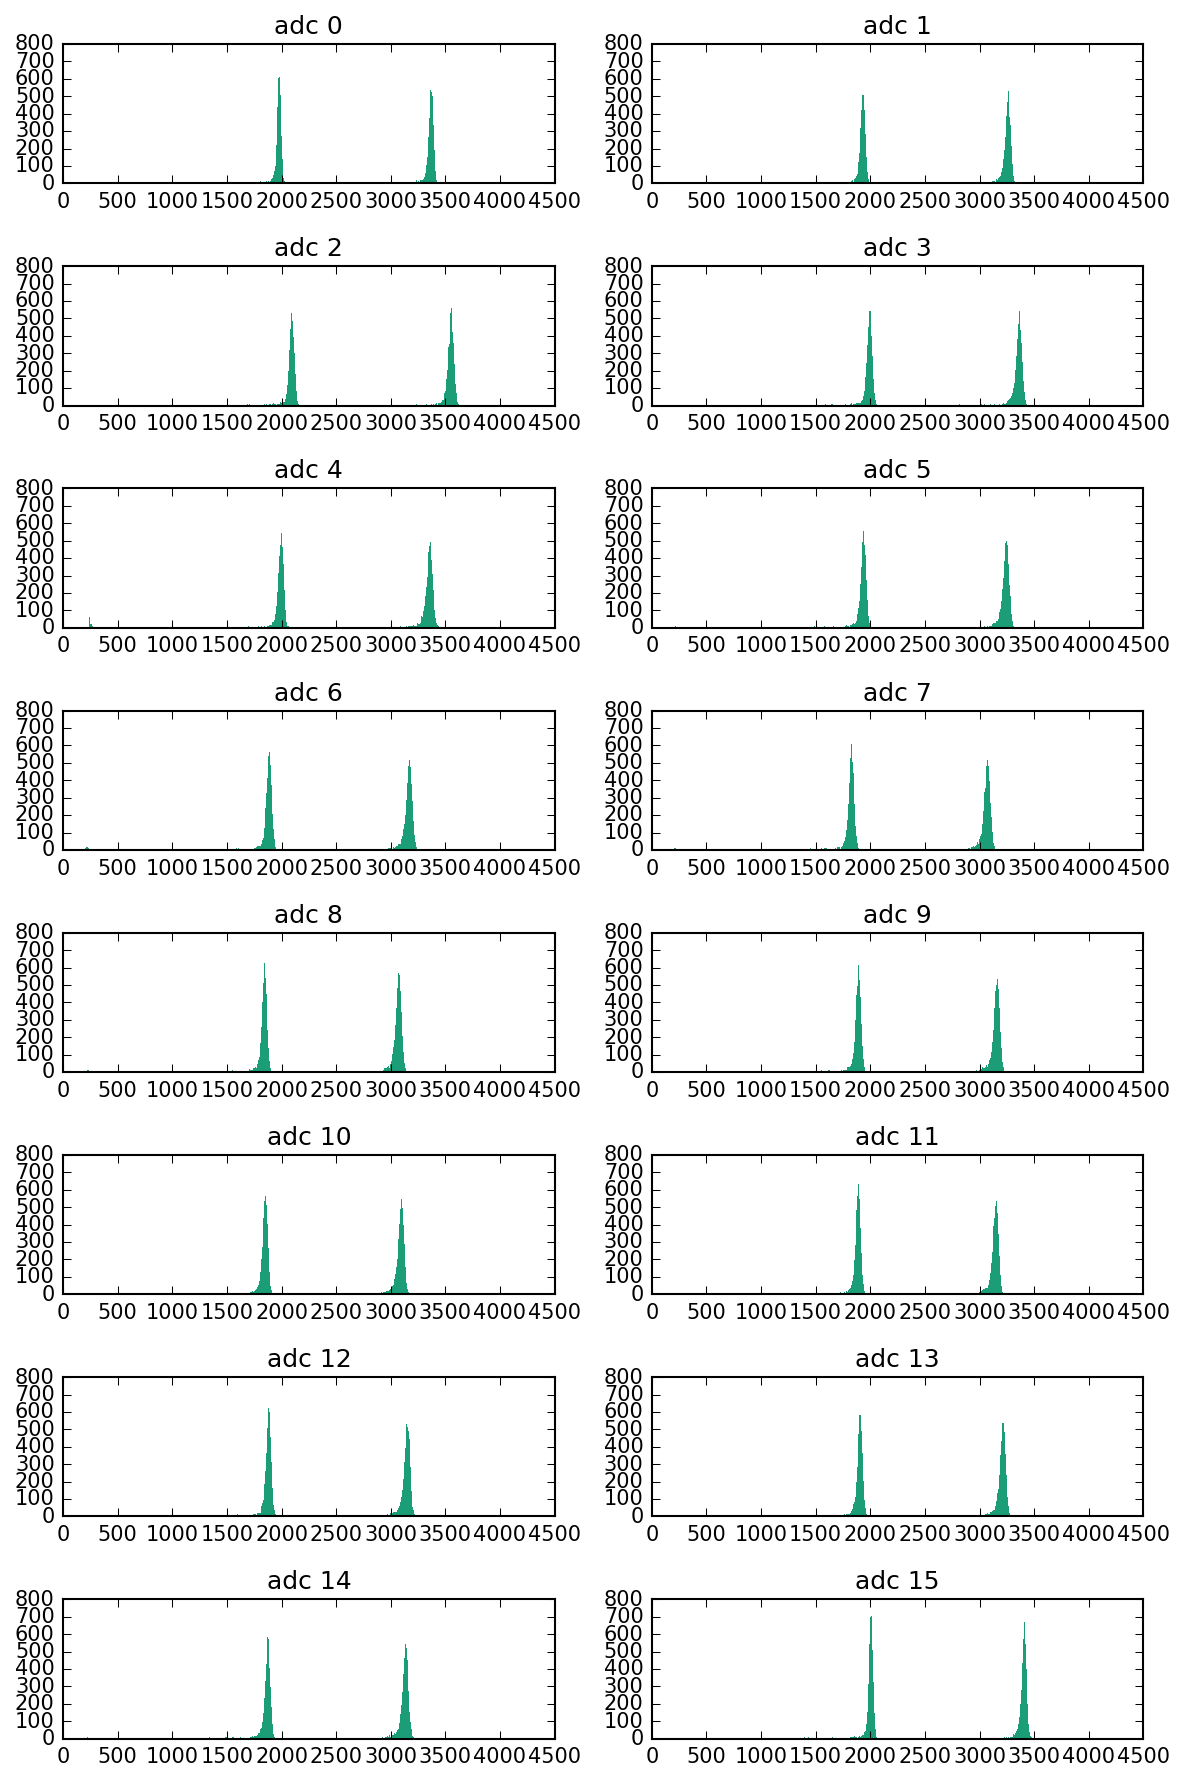

In [5]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(8, 12))
ax = axes.ravel()

for i, (axis, adc) in enumerate(zip(ax, calibration.adc[16:])):
    axis.hist(adc, bins=numpy.arange(4097), alpha=1.0, linewidth=0)
    axis.set_title('adc {}'.format(i))
    axis.set_ylim((0, 800))
#     for _, spine in axis.spines.items():
#         spine.set_visible(False)
#     axis.set_yticks(())
#     axis.tick_params(bottom='off', top='off', left='off', right='off', labelsize=6)
fig.tight_layout()

plt.show()

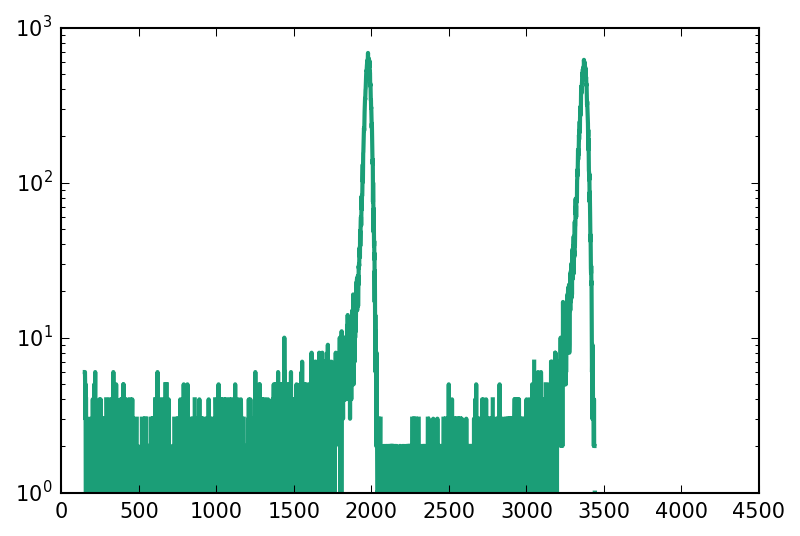

In [64]:
hists = [numpy.histogram(adc, bins=numpy.arange(4097)) for adc in calibration.adc[16:]]

plt.semilogy(hists[0][1][1:], hists[0][0])
plt.show()

In [65]:
from scipy.signal import find_peaks_cwt

# min_snr needed to be tuned... works for 2.1-2.3, so maybe don't tune it and use peak values as discriminant
peaks = find_peaks_cwt(hists[0][0], numpy.arange(50, 100), min_snr=1)
print(peaks)
print(hists[0][0][peaks], hists[0][1][peaks], sep='\n')

[203, 358, 786, 1047, 1400, 1976, 2498, 3369, 3749]
[  3   0   2   0   3 633   5 543   0]
[ 203  358  786 1047 1400 1976 2498 3369 3749]


So, we can say that our threshold for peak size is above 50 (to be conservative).

In [8]:
hists[0][0][peaks] > 50

array([False, False, False, False, False,  True, False,  True, False], dtype=bool)

In [69]:
from scipy.optimize import curve_fit

def gaussian(x, sigma, mu, A):
    return A * numpy.exp(-(x - mu)**2 / (2 * sigma**2))

pars_1, _ = curve_fit(gaussian, hists[0][1][1:], hists[0][0], p0=[20, 1976, 100])
pars_2, _ = curve_fit(gaussian, hists[0][1][1:], hists[0][0], p0=[20, 3369, 100])

sigma:   17.62472 mu: 1977.74917, A:  622.82690
sigma:   20.51097 mu: 3370.58027, A:  561.13920


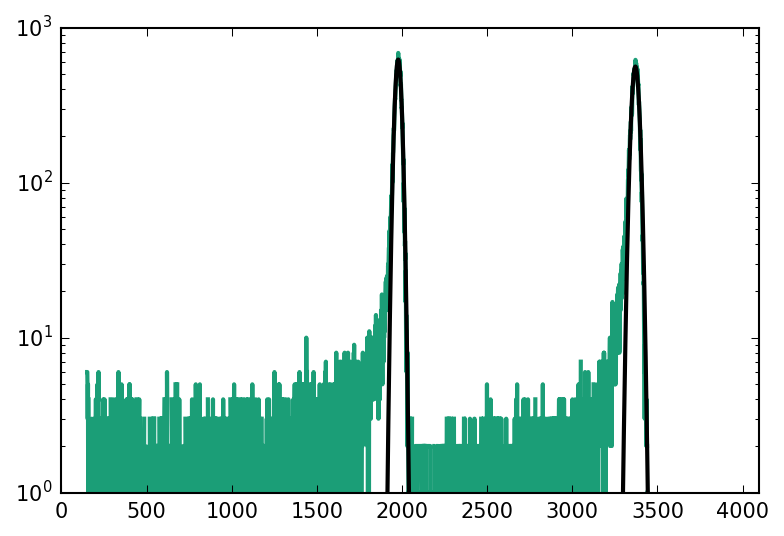

In [70]:
x = numpy.arange(4097)

out = 'sigma: {:10.5f} mu: {:10.5f}, A: {:10.5f}'
print(out.format(*pars_1), out.format(*pars_2), sep='\n')

plt.semilogy(hists[0][1][1:], hists[0][0])
plt.plot(x, gaussian(x, *pars_1), 'k-')
plt.plot(x, gaussian(x, *pars_2), 'k-')
plt.ylim((1, 1000))
plt.xlim((0, 4096))
plt.show()

m:    1.65337 b:  -87.26801


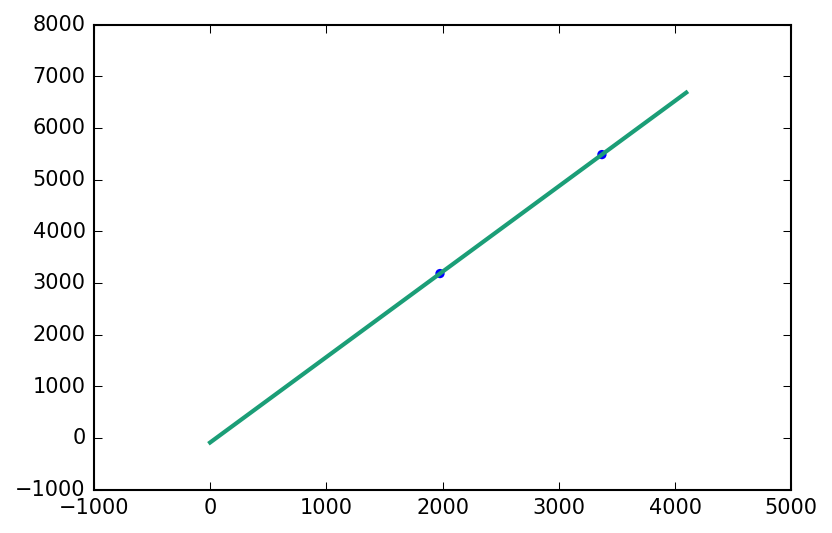

In [11]:
import warnings

cal_x = [pars_1[1], pars_2[1]]
cal_e = [3182.69, 5485.56]

def linear(x, m, b):
    return m * x + b

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    cal_pars, _ = curve_fit(linear, cal_x, cal_e)
print('m: {:10.5f} b: {:10.5f}'.format(*cal_pars))

plt.plot(x, linear(x, *cal_pars))
plt.scatter(cal_x, cal_e)
plt.show()

In [75]:
import statsmodels.api as sm

Y = cal_e
x = cal_x
x = sm.add_constant(x)
print(x, Y)

results = sm.OLS(Y, x).fit()
print(results.params)

[[  1.00000000e+00   1.97774917e+03]
 [  1.00000000e+00   3.37058027e+03]] [3182.69, 5485.56]
[-87.26800953   1.65337347]


In [77]:
test = numpy.arange(100, 3000, 100)
test = sm.add_constant(test)

results.predict(test)

array([   78.06933788,   243.40668529,   408.74403271,   574.08138012,
         739.41872754,   904.75607495,  1070.09342236,  1235.43076978,
        1400.76811719,  1566.10546461,  1731.44281202,  1896.78015943,
        2062.11750685,  2227.45485426,  2392.79220168,  2558.12954909,
        2723.4668965 ,  2888.80424392,  3054.14159133,  3219.47893875,
        3384.81628616,  3550.15363357,  3715.49098099,  3880.8283284 ,
        4046.16567582,  4211.50302323,  4376.84037064,  4542.17771806,
        4707.51506547])

In [46]:
def keep_good_peaks(peak, height):
    if height > 50:
        return peak, height

peaks = [numpy.array(find_peaks_cwt(adc[0], numpy.array([200, 225, 250])))
         for adc in hists]
heights = [adc[0][peak] for adc, peak in zip(hists, peaks)]

peak_heights = [[keep_good_peaks(p, h) for p, h in zip(peak, height) if keep_good_peaks(p, h) is not None]
                for peak, height in zip(peaks, heights)]
peak_heights

[[(1972, 604), (3363, 539)],
 [(1927, 499), (3254, 439)],
 [(2090, 520), (3546, 531)],
 [(1989, 502), (3356, 468)],
 [(1990, 473), (3349, 479)],
 [(1932, 536), (3236, 477)],
 [(1880, 538), (3161, 431)],
 [(1822, 545), (3063, 537)],
 [(1837, 550), (3065, 494)],
 [(1885, 558), (3151, 464)],
 [(1845, 533), (3087, 495)],
 [(1883, 587), (3140, 507)],
 [(1876, 580), (3142, 428)],
 [(1901, 585), (3207, 537)],
 [(1867, 538), (3127, 495)],
 [(2001, 700), (3403, 597)]]

In [58]:
peak_heights = numpy.array(peak_heights).reshape(-1, 4)
peak_0 = peak_heights[:, 0]
peak_0_height = peak_heights[:, 1]
# peak_heights

# peak_filter = peak_0[peak_0_height > 500]
peak_0[peak_0_height > 500]

array([1972, 2090, 1989, 1932, 1880, 1822, 1837, 1885, 1845, 1883, 1876,
       1901, 1867, 2001])

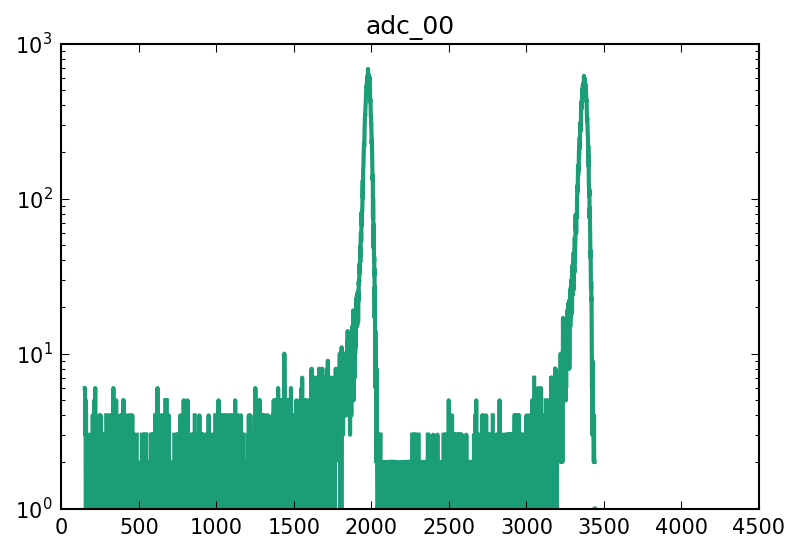

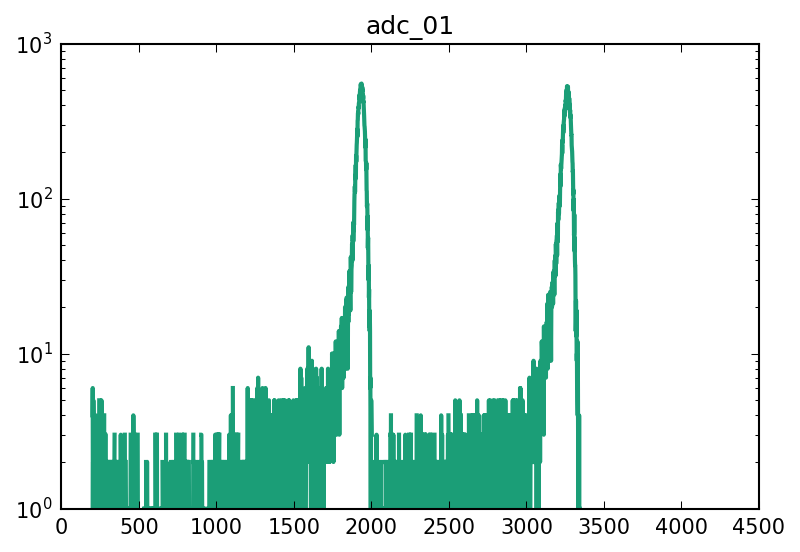

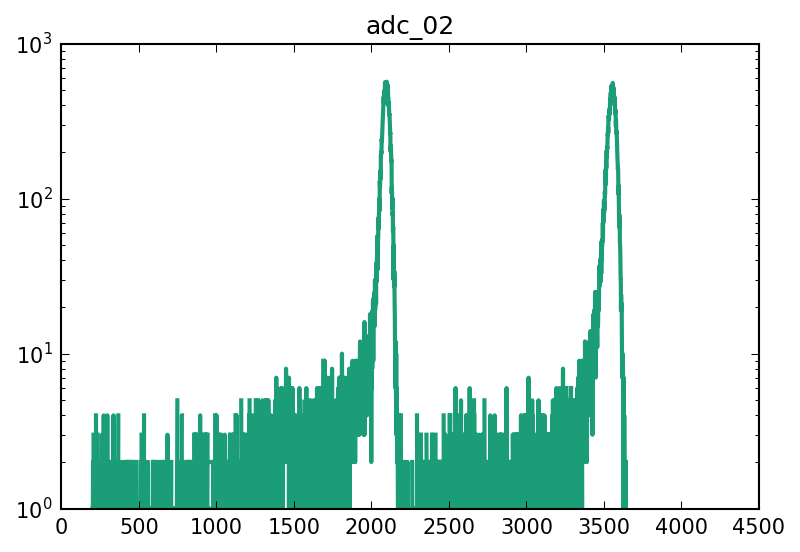

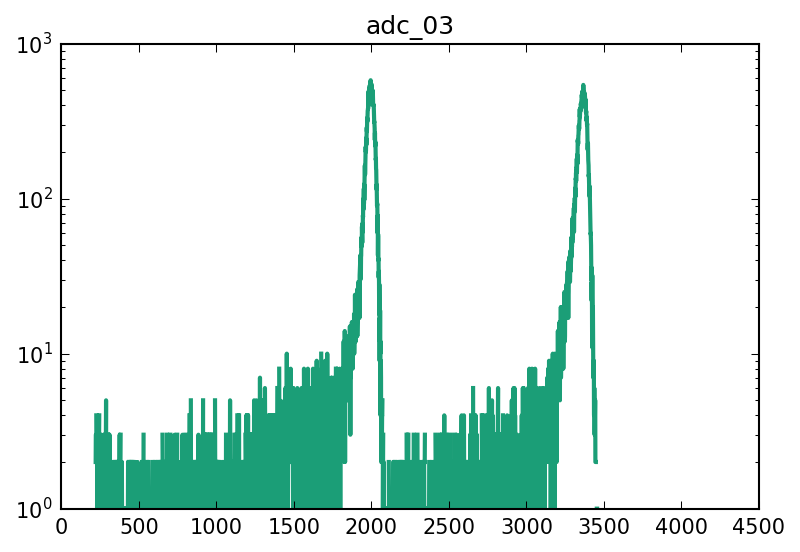

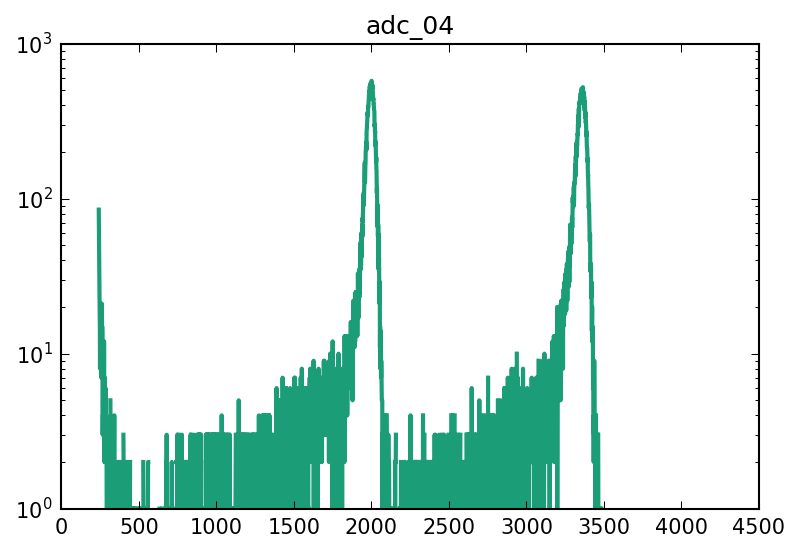

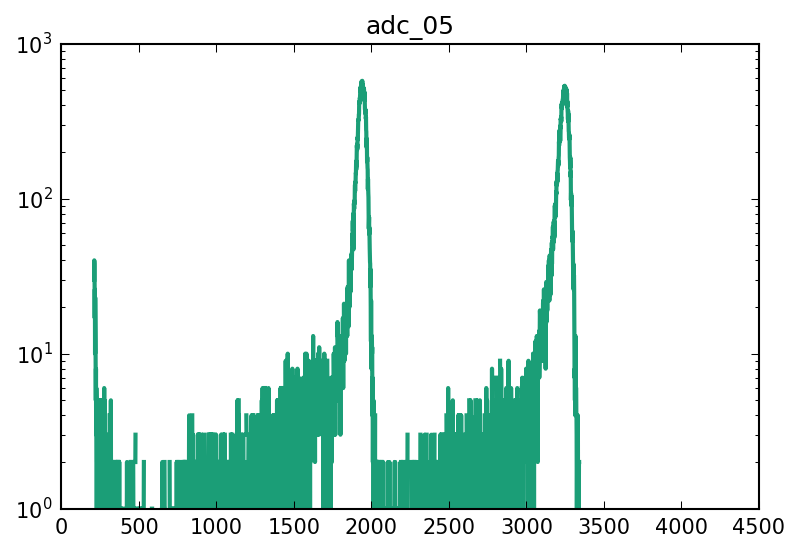

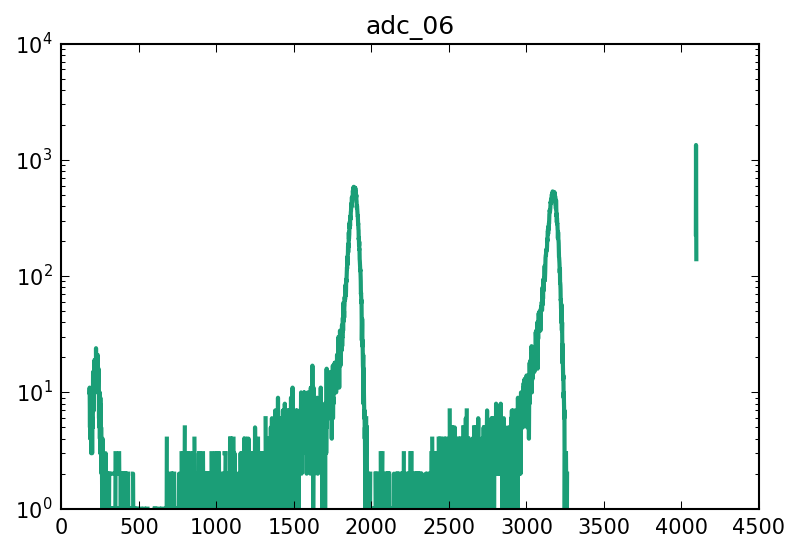

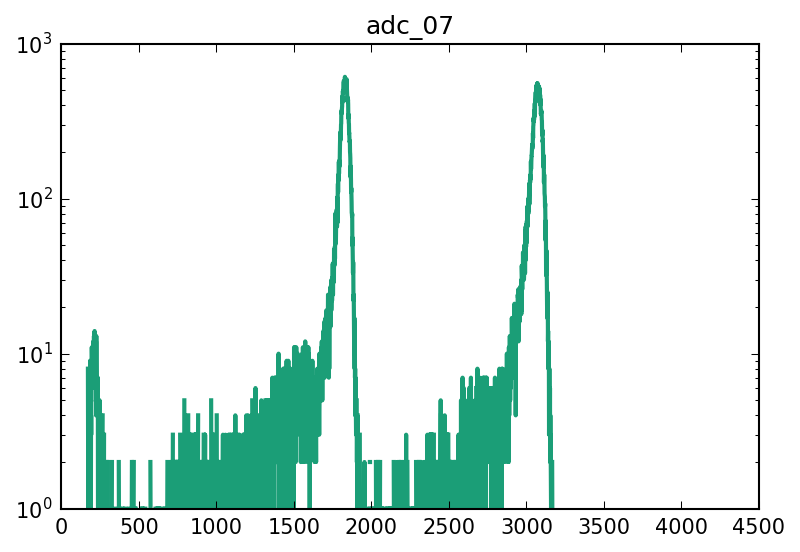

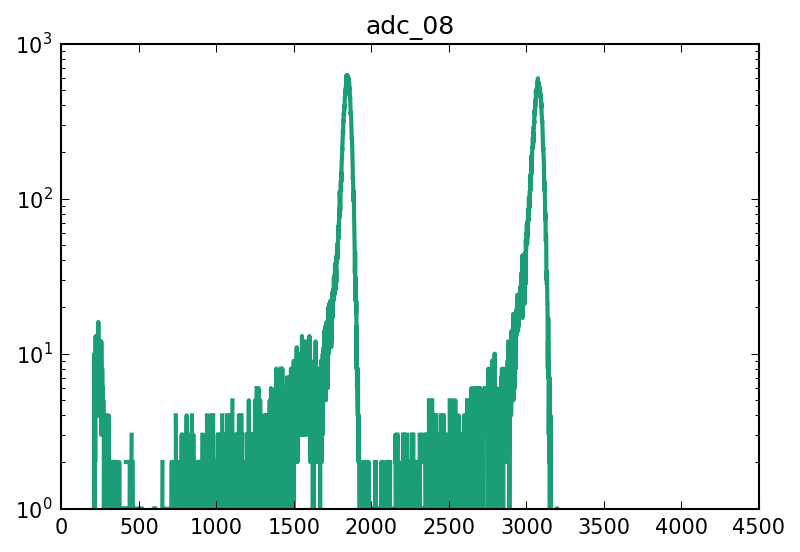

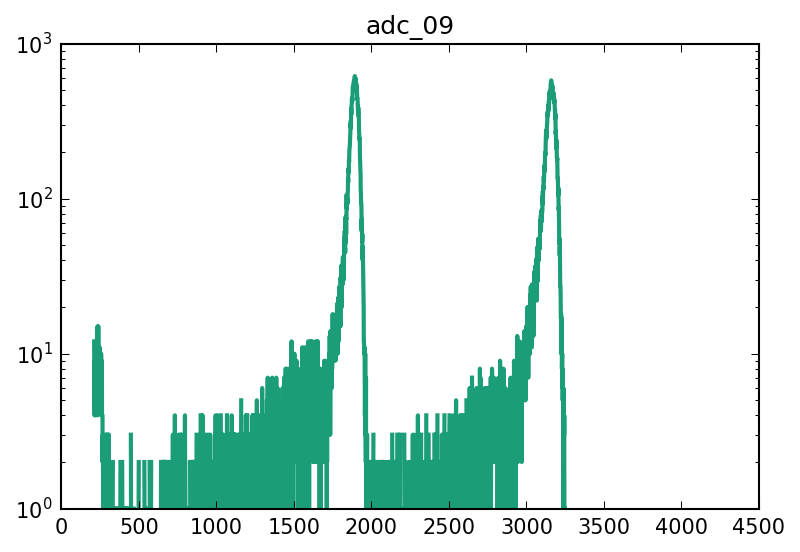

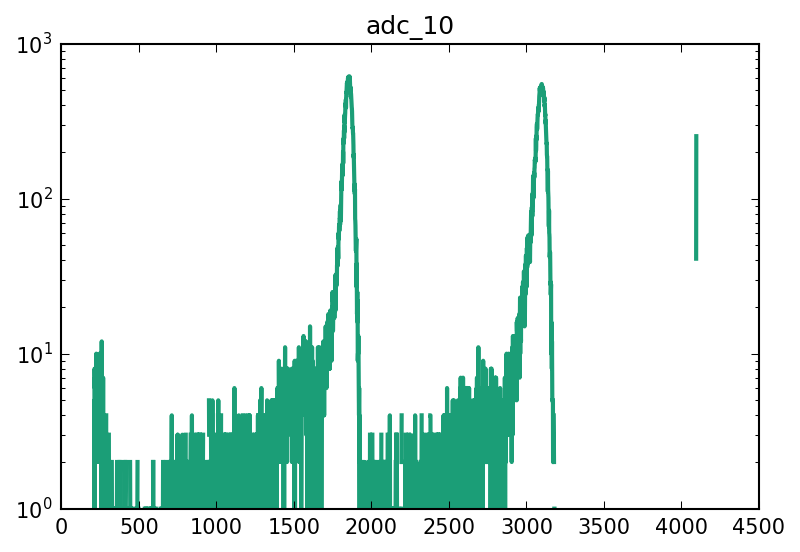

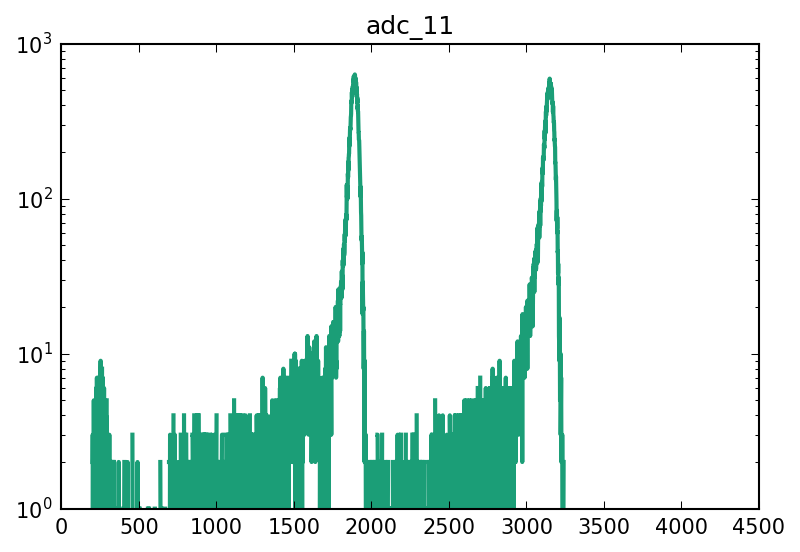

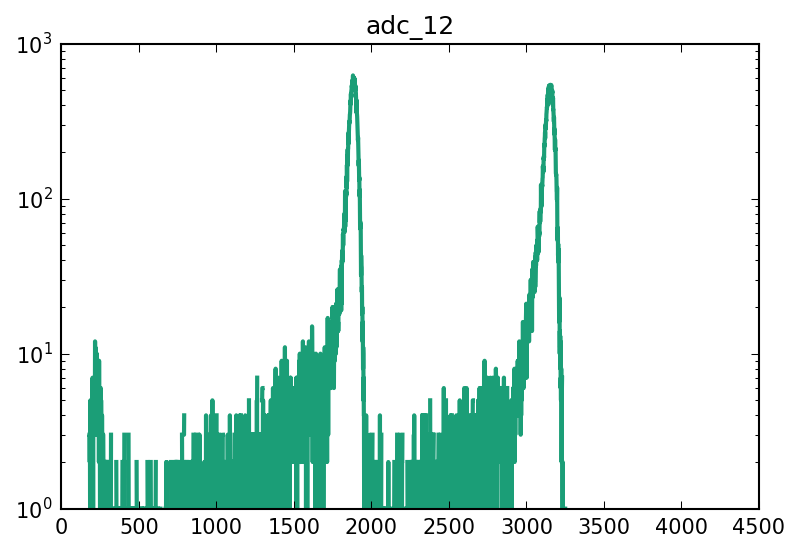

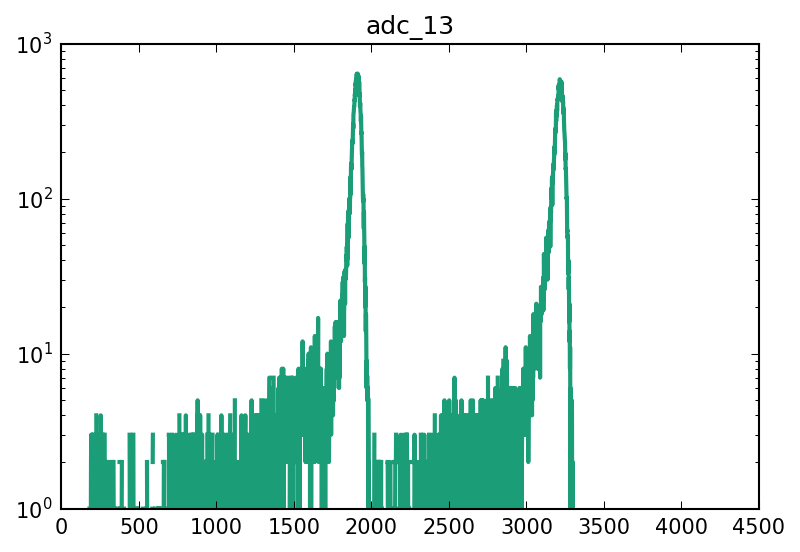

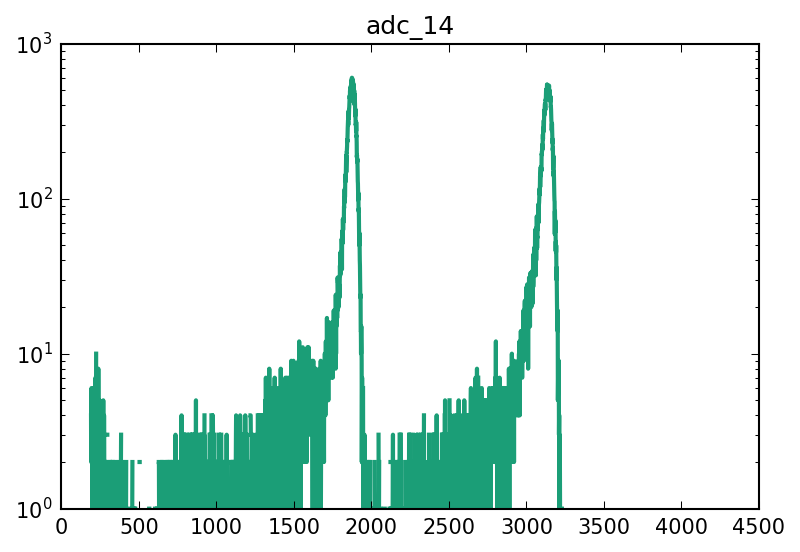

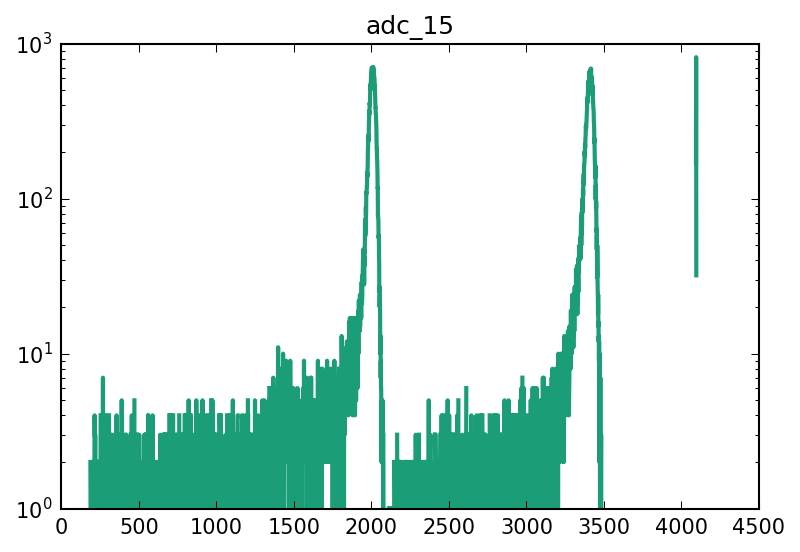

In [16]:
for i, hist in enumerate(hists):
    plt.semilogy(hist[1][1:], hist[0])
    plt.title('adc_{:02d}'.format(i))
    plt.show()

In [17]:
calibration.adc[26]

array([1869, 1874, 1880, ..., 1898, 1814, 1859])

In [18]:
counts, _ = numpy.histogram(calibration.adc[26], bins=numpy.arange(4097))
counts

array([  0,   0,   0, ...,   0,  41, 253])

In [19]:
(calibration.adc[26] == 4095).sum()

253